# Analisis exploratorio

### Links
- [Dataset](https://eval.ai/web/challenges/challenge-page/1721/overview)
- [SentenceTransformers](https://www.sbert.net/)
- [UMAP](https://umap-learn.readthedocs.io/en/latest)
- [Plotting UMAP results](https://umap-learn.readthedocs.io/en/latest/plotting.html)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../src')

from matplotlib import pyplot as plt
import seaborn  as sns

import numpy  as np
import pandas as pd
import torch

import logging
import random

import data  as dt
import model as ml
import util  as ut
import pytorch_common.util as pu

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 11 files to the new cache system


  0%|          | 0/11 [00:00<?, ?it/s]

## Setup

Se configura el default logger para que la consola sea el output y loguee mensajes a partir del nivel INFO.

In [3]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

Chequeamos si se detecta la GPU:

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.__version__

'1.12.1+cu116'

Por defecto usamos GPU. De no existir este hardware, el fallback es CPU:

In [6]:
pu.set_device_name('gpu')

logging.info(pu.get_device())

2022-09-17 15:46:15,879 - INFO - cuda:0


In [7]:
torch.cuda.get_arch_list()

['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86']

Fijamos la semilla:

In [8]:
def set_seed(value):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)

In [9]:
set_seed(42)

Parametros de la notebook:

In [10]:
DATASET_PATH = '../../datasets/fashion-outfits'

### Funciones helper

In [107]:
def plot_categories(groups):
    plt.figure(figsize=(15,7))
    ax = sns.barplot(x='branch', y='id', data=groups)
    ax.set(xlabel=None)
    ax.set(xticklabels=[])
    plt.show()

In [186]:
def append(hash_table, key, value):
    if key not in hash_table:
        hash_table[key] = []
    hash_table[key].append(value)

def branches_to_data_frame(df, column, separator='~', null_value=None):
    count_df = df[column].value_counts()

    branches = [[v.strip() for v in value.split(separator)] for value in count_df.index]
    n_levels = max([len(b) for b in branches])
    
    data = {}
    for branch in branches:
        last_level = 0
        for level, value in enumerate(branch):
            last_level = level
            append(data, f'level_{level}', '' if value == null_value else value)

    data = pd.DataFrame(data) \
        .dropna(how='all', axis=1) \
        .dropna(axis=0)
    data['count'] = count_df.values.tolist()
    return data

## Preparar dataset

In [202]:
dataset = pd.read_parquet(f'{DATASET_PATH}/products.parquet')
dataset.head()

,product_id,product_family,product_category,product_sub_category,product_gender,product_main_colour,product_second_color,product_brand,product_materials,product_short_description,product_attributes,product_image_path,product_highlights
0,17073270,Clothing,Knitwear,Cardi-Coats,UNISEX,BLACK,WHITE,STELLA MCCARTNEY,[Cotton],x The Beatles intarsia-knit coat,"[{""attribute_name"":""Knit Neckline"",""attribute_...",17/07/32/70/17073270.jpg,"[black/white, organic cotton, mix print, intar..."
1,17674562,Clothing,Knitwear,Cardi-Coats,UNISEX,PURPLE,N/D,extreme cashmere,"[Spandex/Elastane, Nylon, Cashmere]",cashmere-blend long belted cardigan,"[{""attribute_name"":""Knit Neckline"",""attribute_...",17/67/45/62/17674562.jpg,"[plum purple, cashmere blend, wrap design, sle..."
2,17678603,Clothing,Knitwear,Cardi-Coats,UNISEX,BLUE,N/D,extreme cashmere,"[Spandex/Elastane, Cashmere, Nylon]",cashmere-blend long belted cardigan,"[{""attribute_name"":""Knit Neckline"",""attribute_...",17/67/86/03/17678603.jpg,"[blue, cashmere blend, wrap design, sleeveless..."
3,17179699,Clothing,Knitwear,Cardi-Coats,UNISEX,PINK,N/D,extreme cashmere,"[Nylon, Spandex/Elastane, Cashmere]",long cashmere cardigan,"[{""attribute_name"":""Knit Neckline"",""attribute_...",17/17/96/99/17179699.jpg,"[light pink, stretch-cashmere blend, fine knit..."
4,15907453,Clothing,Sweaters & Knitwear,Cardigans,MEN,NEUTRALS,N/D,THE ELDER STATESMAN,[Cashmere],tie-dye print cashmere cardigan,None,15/90/74/53/15907453.jpg,"[multicolour, cashmere, tie-dye print, knitted..."


In [203]:
def norm_text(df, columns):
    for col in columns:
        df[col] = df[col].apply(lambda x: x.lower().strip())

TEXT_COLS = ['product_family', 'product_category', 'product_sub_category', 'product_brand', 'product_gender']
        
norm_text(dataset, TEXT_COLS)


dataset = dataset.rename(columns={
    'product_id'               : 'id',
    'product_gender'           : 'gender',    
    'product_short_description': 'description', 
    'product_highlights'       : 'highlights',
    'product_image_path'       : 'image',
    'product_materials'        : 'materials',
    'product_family'           : 'family',
    'product_category'         : 'category',
    'product_sub_category'     : 'sub_category', 
    'product_brand'            : 'brand',
    'product_main_colour'      : 'main_colour', 
    'product_second_color'     : 'second_color'
})


products = dataset[['id', 'family', 'category', 'sub_category', 'description', 'highlights', 'brand', 'gender', 'materials']]
products['branch'] = products['family'] + '~' + products['category'] + '~' + products['sub_category']

products.dropna(how='all', axis=1).dropna(axis=0)
products.head()

,id,family,category,sub_category,description,highlights,brand,gender,materials,branch
0,17073270,clothing,knitwear,cardi-coats,x The Beatles intarsia-knit coat,"[black/white, organic cotton, mix print, intar...",stella mccartney,unisex,[Cotton],clothing~knitwear~cardi-coats
1,17674562,clothing,knitwear,cardi-coats,cashmere-blend long belted cardigan,"[plum purple, cashmere blend, wrap design, sle...",extreme cashmere,unisex,"[Spandex/Elastane, Nylon, Cashmere]",clothing~knitwear~cardi-coats
2,17678603,clothing,knitwear,cardi-coats,cashmere-blend long belted cardigan,"[blue, cashmere blend, wrap design, sleeveless...",extreme cashmere,unisex,"[Spandex/Elastane, Cashmere, Nylon]",clothing~knitwear~cardi-coats
3,17179699,clothing,knitwear,cardi-coats,long cashmere cardigan,"[light pink, stretch-cashmere blend, fine knit...",extreme cashmere,unisex,"[Nylon, Spandex/Elastane, Cashmere]",clothing~knitwear~cardi-coats
4,15907453,clothing,sweaters & knitwear,cardigans,tie-dye print cashmere cardigan,"[multicolour, cashmere, tie-dye print, knitted...",the elder statesman,men,[Cashmere],clothing~sweaters & knitwear~cardigans


# Visualización de categorias de productos

La columna branch representa la rama del arbol de categorias donde se encuentra un producto.

In [192]:
branches = products['branch']
branches.head()

0             clothing~knitwear~cardi-coats
1             clothing~knitwear~cardi-coats
2             clothing~knitwear~cardi-coats
3             clothing~knitwear~cardi-coats
4    clothing~sweaters & knitwear~cardigans
Name: branch, dtype: object

**Observaciones**

* Se peude apreciar que cada producto se encuetra dentro de una categoria hoja dentro del un arbolde categorias.
* A su vez pertenese a una categoria padre.
* El arbol de categoroas parece tener unicamente 3 niveles.

Creamos un data frame con todas las ramas/arista del arbol de categorias, Luiego graficamos la jerarquia de categorias, especificando la cantidad de productos por cada categoria:

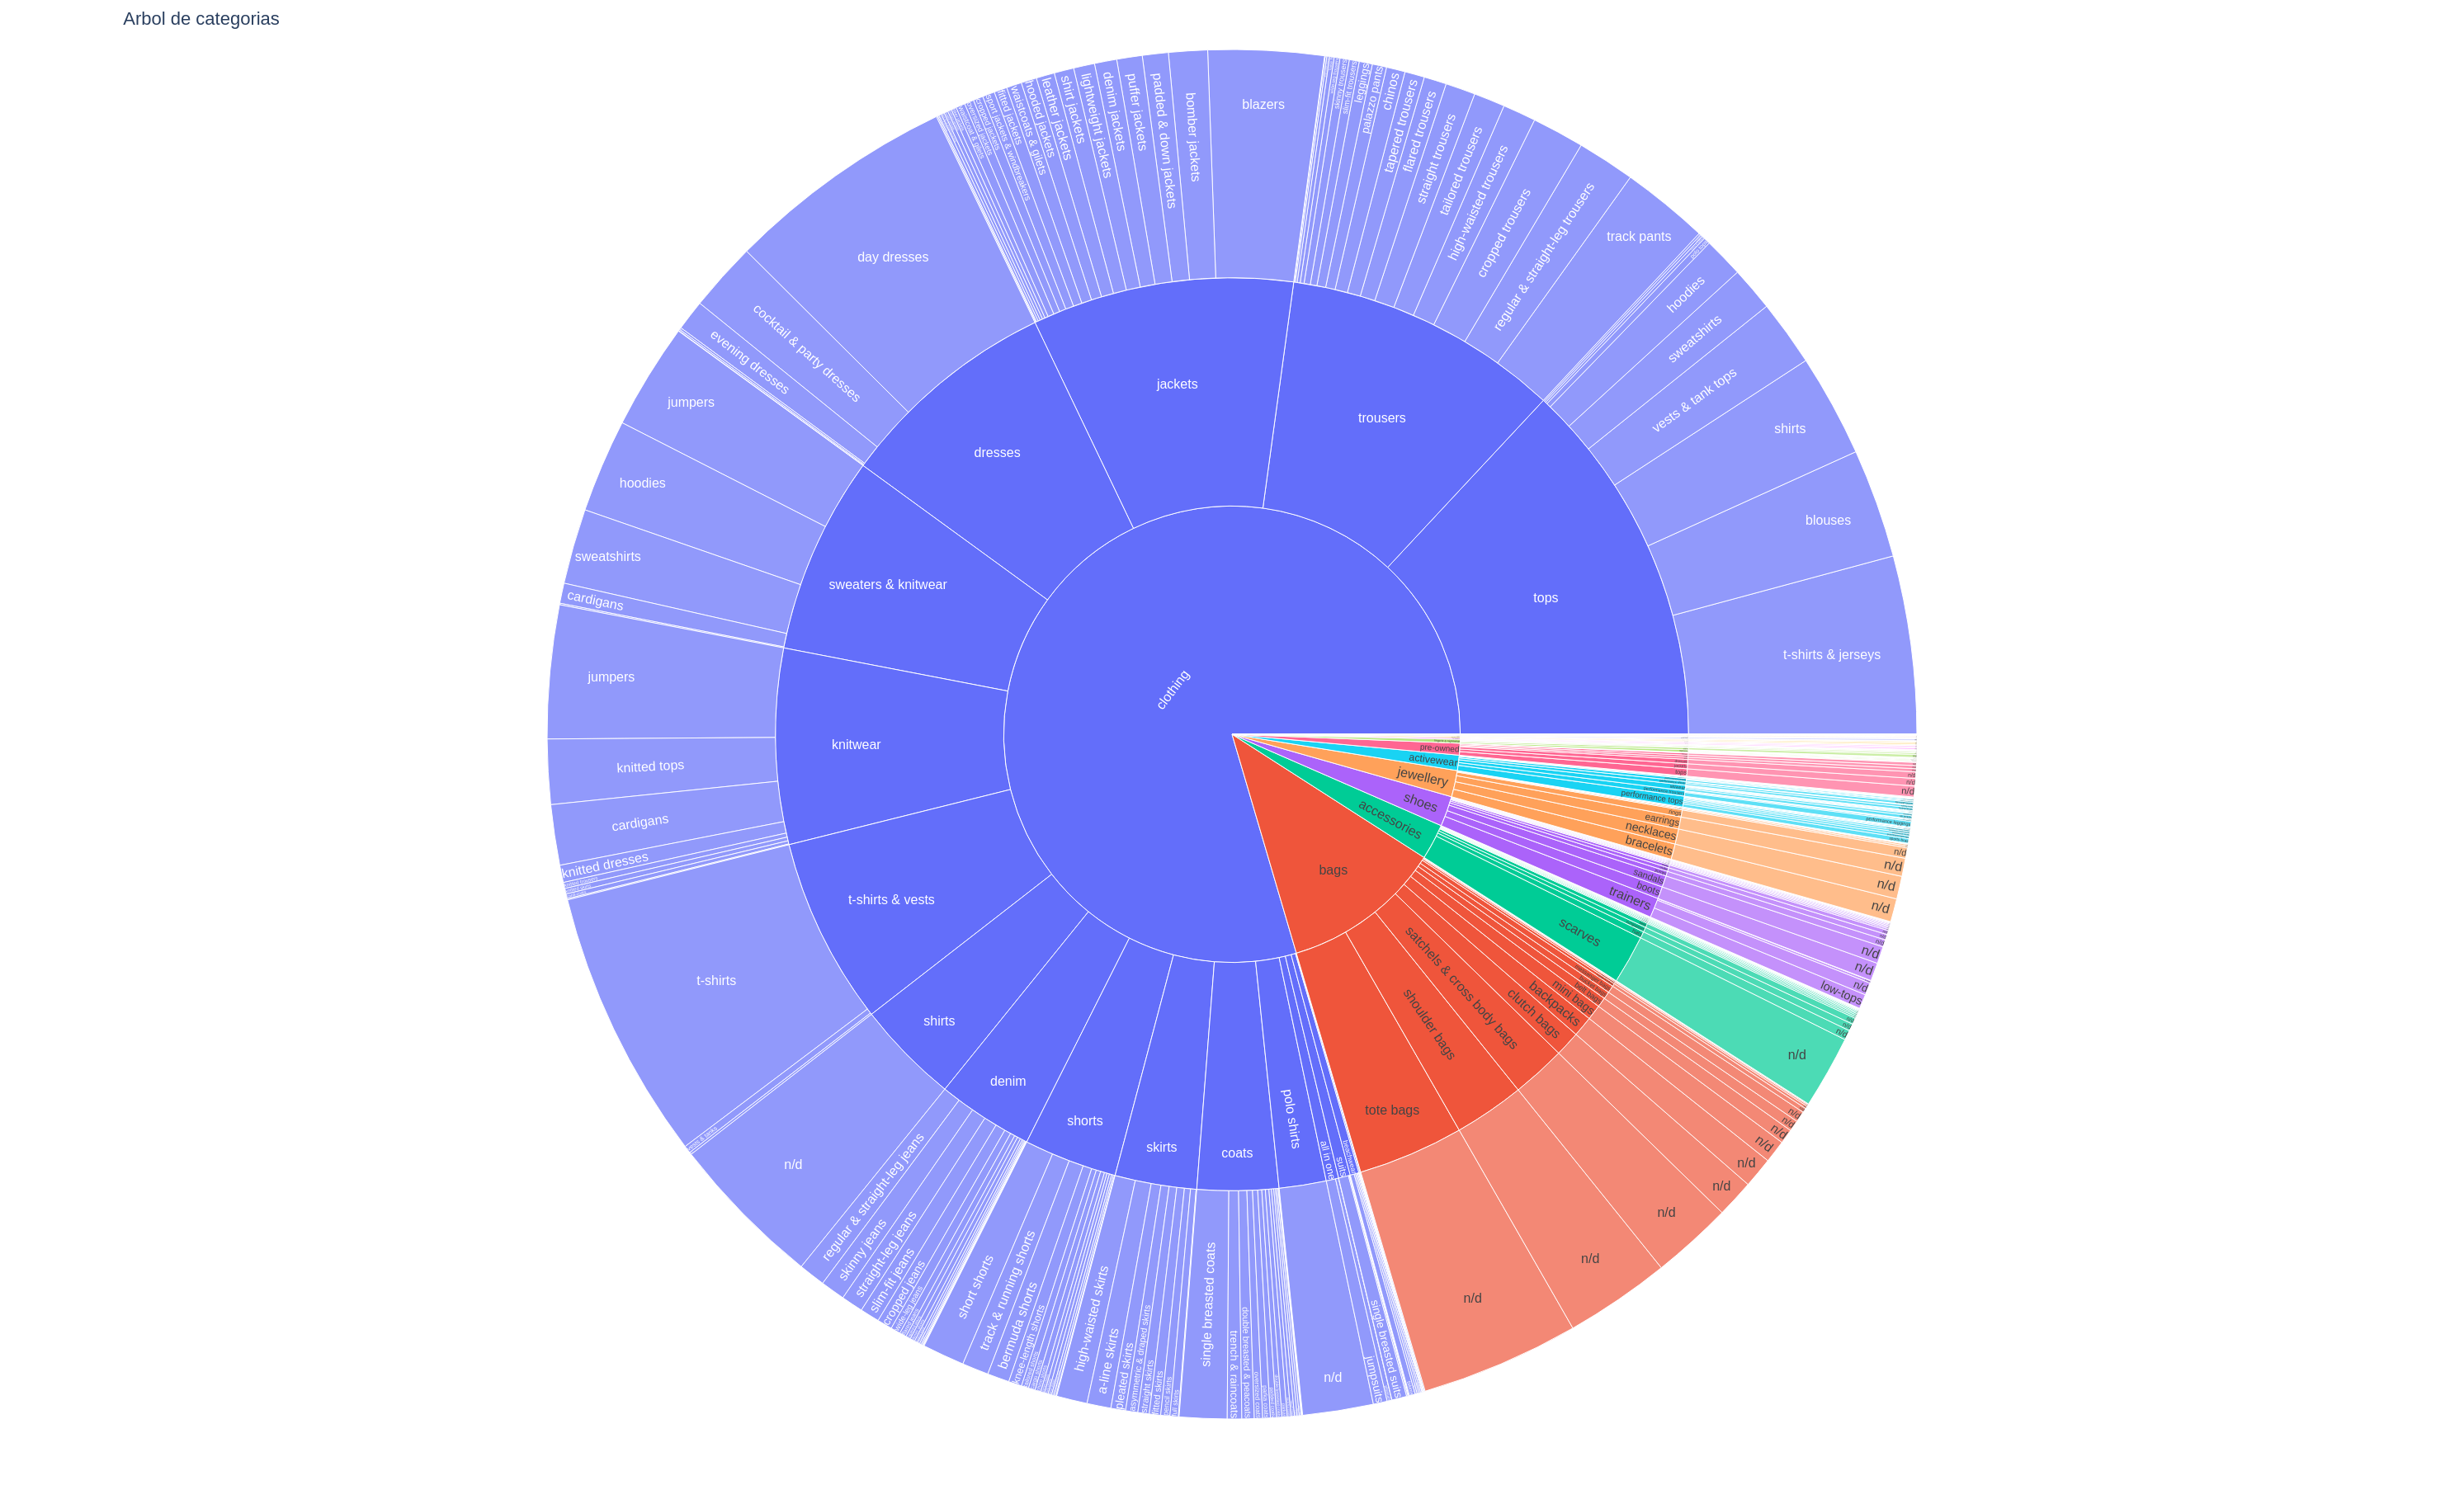

In [193]:
dt.plot_tree(
    df    = branches_to_data_frame(products, 'branch'), 
    title = 'Arbol de categorias'
)

## Cantidad de productos por rama

<Figure size 1500x700 with 1 Axes>

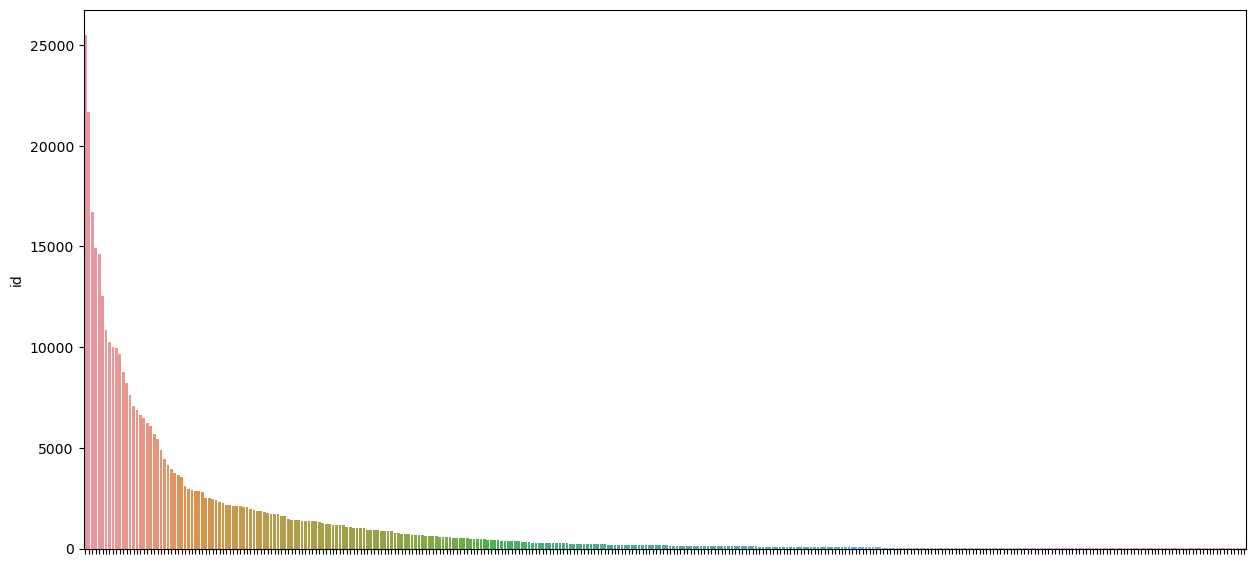

In [194]:
plot_categories(ut.group_by_count(products, ['branch'], 'id'))

## Cluster de categorias

A continacion se generan embeddings para cada categoria y título. Luego, se reduce la dimensionalidad de los embeddings para poder graficar su similitud en dos dimensiones:

In [195]:
sentence_encoder = ml.SentenceEncoder('all-MiniLM-L6-v2')

2022-09-17 17:20:22,879 - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2022-09-17 17:20:23,006 - INFO - Use pytorch device: cuda


In [196]:
categories = np.unique(products['branch'])

category_embeddindgs = sentence_encoder(categories)

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Opening in existing browser session.


[2693534:2693534:0100/000000.512139:ERROR:vaapi_wrapper.cc(1299)] vaQuerySurfaceAttributes failed, VA error: invalid parameter
[2693534:2693534:0100/000000.512165:ERROR:vaapi_wrapper.cc(1246)] FillProfileInfo_Locked failed for va_profile VAProfileH264Main and entrypoint VAEntrypointVLD
[2693534:2693534:0100/000000.512177:ERROR:vaapi_wrapper.cc(1299)] vaQuerySurfaceAttributes failed, VA error: invalid parameter
[2693534:2693534:0100/000000.512185:ERROR:vaapi_wrapper.cc(1246)] FillProfileInfo_Locked failed for va_profile VAProfileH264High and entrypoint VAEntrypointVLD


338

<Figure size 1000x1000 with 1 Axes>

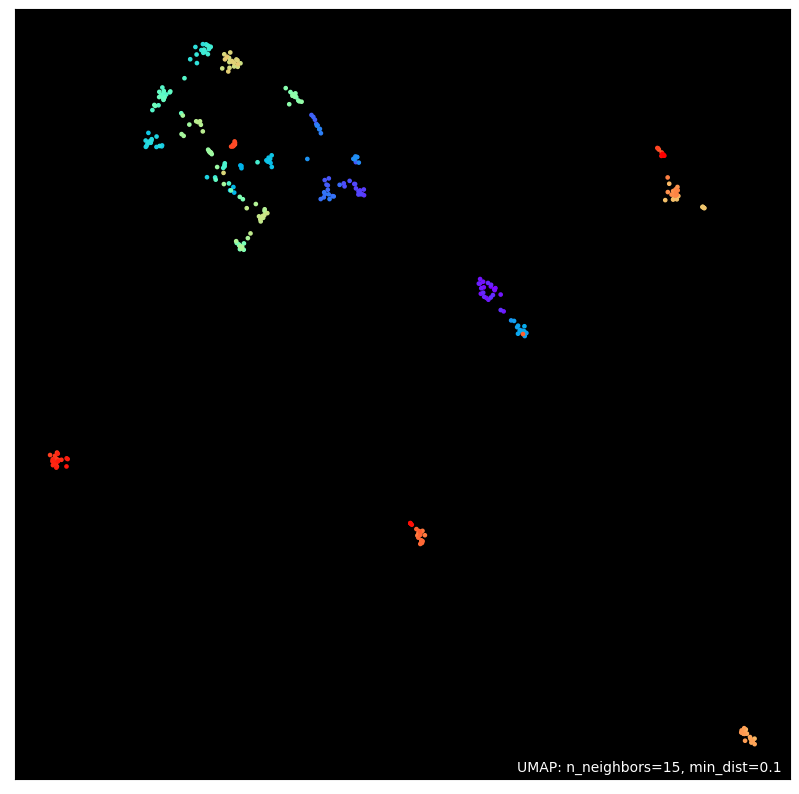

<Figure size 1000x1000 with 1 Axes>

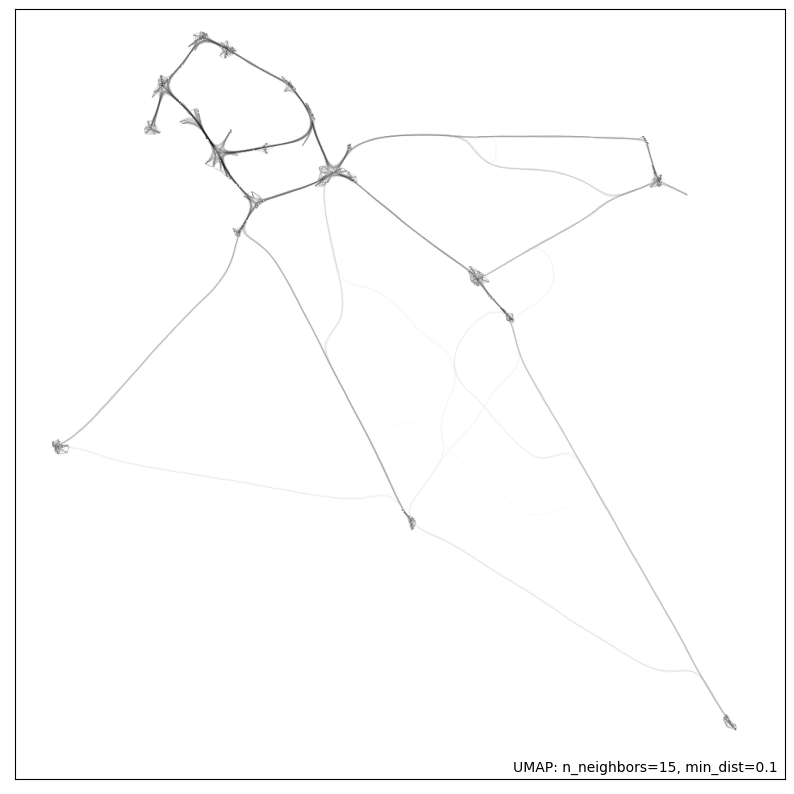

In [198]:
ml.UMAP(category_embeddindgs) \
    .plot_clusters(labels=categories) \
    .plot_interactive_clusters(labels=categories) \
    .plot_connectivity()

len(categories)

## Cluster de productos por similitud entre descriptiones

A continuación, se generan embeddings para cada descripción. Luego, se reduce la dimensionalidad para visualizar la distancia entre descripciones deacuerdo a su similitud. Los colores representan las categorias a las que pertenece cada description/producto.

In [229]:
desc_cat_df = products[['description', 'branch']].drop_duplicates()
# desc_cat_df = desc_cat_df.sample(n=10000, random_state=1)

descs  = desc_cat_df['description'].dropna().values
labels = desc_cat_df['branch'].dropna().values

descs.shape, labels.shape

((243364,), (243364,))

In [230]:
desc_embeddindgs = sentence_encoder(descs)

Batches:   0%|          | 0/7606 [00:00<?, ?it/s]

<model.umap.UMAP object at 0x7fc7f2448b80>

<Figure size 1000x1000 with 1 Axes>

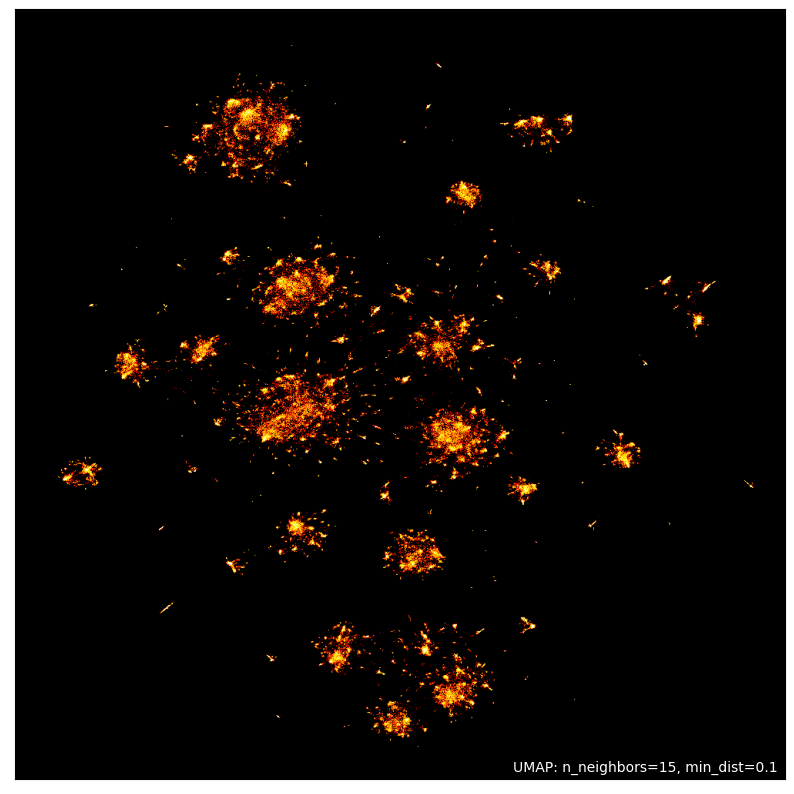

In [231]:
ml.UMAP(desc_embeddindgs).plot_clusters(labels=None)

#  Description de productos

<Figure size 1500x700 with 1 Axes>

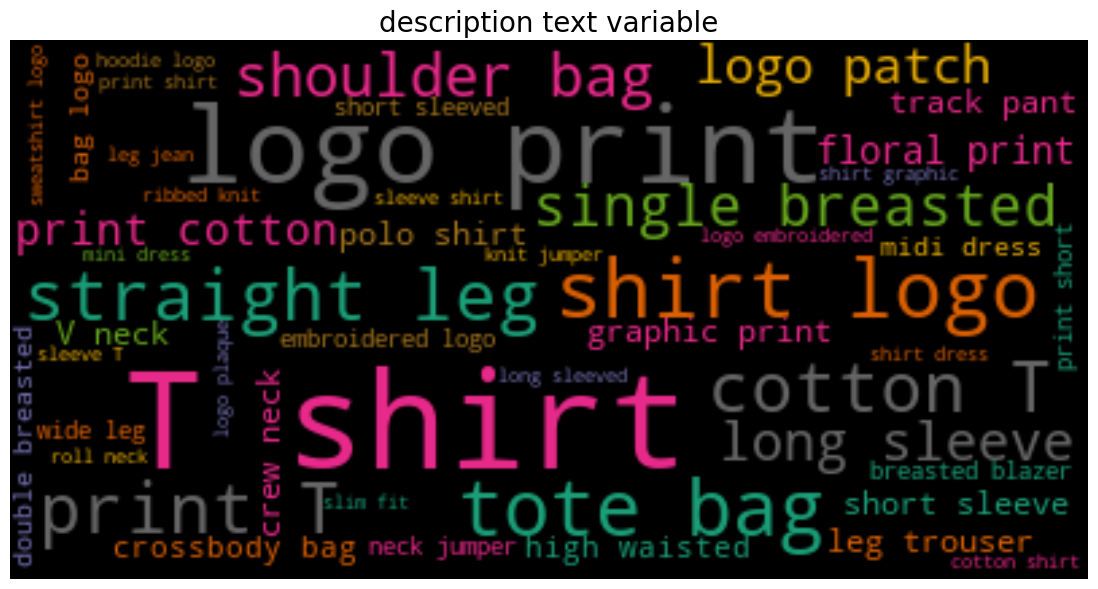

In [233]:
plt.figure(figsize=(15,7))
dt.describe_text_var(products, 'description')

In [234]:
products['description']

0            x The Beatles intarsia-knit coat
1         cashmere-blend long belted cardigan
2         cashmere-blend long belted cardigan
3                      long cashmere cardigan
4             tie-dye print cashmere cardigan
                         ...                 
398665                   wide-leg denim jeans
398666                   wide-leg denim jeans
398667                  cropped balloon jeans
398668            high-waisted wide-leg jeans
398669               high-rise wide-leg jeans
Name: description, Length: 398670, dtype: object

In [232]:
products.to_csv(f'{DATASET_PATH}/products.csv', index=False)